In [1]:
from datasets import load_dataset
dataset = load_dataset("csv", data_files={"train":['train_data2.csv'], "val":['val_data2.csv'], "test":['test_data2.csv']})

c:\Users\mmmil\anaconda3\envs\linkbert\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using custom data configuration default-1d6b7bc23d832134
Reusing dataset csv (C:\Users\mmmil\.cache\huggingface\datasets\csv\default-1d6b7bc23d832134\0.0.0\9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)


In [2]:
### linkbert ###
from torch import nn
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer, AutoModelForSequenceClassification,BertForSequenceClassification 

tokenizer = AutoTokenizer.from_pretrained('michiyasunaga/BioLinkBERT-base')
model = BertForSequenceClassification.from_pretrained(r"D:\ai_base_prog\linkber\results_20221027_205634\checkpoint-4005")

In [3]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512) #max_length=512
tokenized_data = dataset.map(preprocess_function, batched=True)

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auroc': auc
    }

Parameter 'function'=<function preprocess_function at 0x0000018CED5841F0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|██████████| 2/2 [00:00<00:00, 32.42ba/s]


In [4]:
import datetime

training_args = TrainingArguments(
    output_dir=f"./results_link_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=100,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [6]:
metrics = trainer.evaluate(tokenized_data["test"])

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 1067
  Batch size = 4
 99%|█████████▉| 265/267 [00:10<00:00, 31.95it/s]Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ckdtjs0609. Use `wandb login --relogin` to force relogin


100%|██████████| 267/267 [00:12<00:00, 20.66it/s]


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 1067
  Batch size = 4
100%|██████████| 267/267 [00:09<00:00, 33.62it/s]

test_loss  :  0.09496653079986572
test_accuracy  :  0.985941893158388
test_f1  :  0.940711462450593
test_precision  :  0.9015151515151515
test_recall  :  0.9834710743801653
test_auroc  :  0.9848645012492792
test_runtime  :  11.4196
test_samples_per_second  :  93.436
test_steps_per_second  :  23.381


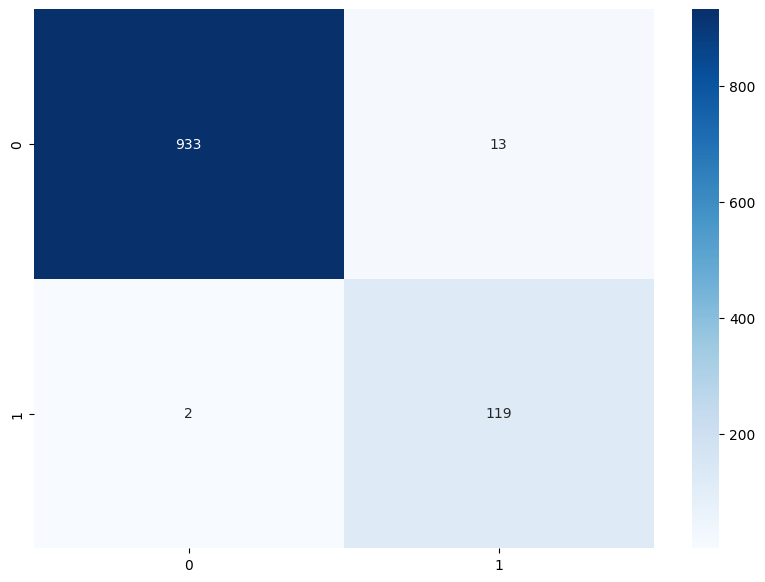

In [5]:
metrics = trainer.predict(tokenized_data["test"])
import numpy as np

y_pred = []
for i in metrics.predictions:
    a= np.argmax(i)
    y_pred.append(a)
y_true = metrics.label_ids

import sklearn 
confusion_matrix = sklearn.metrics.confusion_matrix(list(y_true), list(y_pred))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix, index = ['0','1'],
                  columns = ['0','1'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='')
for i in metrics.metrics:
    print(i,' : ',metrics.metrics[i])

In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd 

data = pd.read_csv(r'D:\ai_base_prog\train_set_no_duplicates.csv',encoding='euc-kr')
data['text'] = data['Findings'].fillna('-') + data['Conclusion\n'].fillna('-')
data = data.drop(columns=['Findings', 'Conclusion\n'])
data = data.rename(columns={'AcuteInfarction':'label'})

x_train, x_valid, y_train, y_valid = train_test_split(data['text'], data['label'], test_size=0.2, shuffle=True, stratify=data['label'], random_state=34)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, shuffle=True, stratify=y_train, random_state=34)

for i in range(len(y_true)):
    if y_true[i]!=y_pred[i]:
        print(x_test.values[i],y_test.values[i])
        print('---------------------------------------------------------------------------')

Clinical information : multiple cerebral infarction

Axial T1WI, sagittal T1WI, axial T2WI, axial FLAIR, axial T2* GRE image, intracranial TOF MRA 획득하였으며 neck MRA에 대해서 조영증강을 시행함.
1. Chronic infarctions in right MCA territory, both frontal lobes, left temporal lobe.
    - limited evaluation of infarction without DWI.
2. Microbleeds in both frontoparietotemporal lobes, c/w DAI. 
3. Right otomastoiditis.
4. Left mastoid effusion.
5. Both sphenoid sinusitis.
6. MRA : both MCA occlusion

 0
---------------------------------------------------------------------------
-acute infarction at the left basal ganglia, small size
MRA: compare to the latest MRA;  interval improving state of stenosis of the right MCA
 0
---------------------------------------------------------------------------
Clinical information : lung cancer

Axial T1WI, sagittal T1WI, axial T2WI, axial FLAIR, axial T2* GRE image 획득하였으며 조영증강을 시행함.

a 6mm sized enhancing lesion with microbleeds at the left BG
    → indeterminate enh

100%|██████████| 267/267 [00:22<00:00, 33.62it/s]

In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd 

data = pd.read_csv(r'C:\Users\mmmil\Downloads\ansgkrtksghfkddl.csv')
data['text'] = data['Findings'] + data['Conclusion']
data = data.drop(columns=['Findings', 'Conclusion'])
data = data.rename(columns={'AcuteInfarction':'label'})

x_train, x_valid, y_train, y_valid = train_test_split(data['text'], data['label'], test_size=0.2, shuffle=True, stratify=data['label'], random_state=34)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, shuffle=True, stratify=y_train, random_state=34)

for i in range(len(y_true)):
    if y_true[i]!=y_pred[i]:
        print(x_test.values[i],y_test.values[i])
        print('---------------------------------------------------------------------------')

CI, 양다리, 좌측 팔 위약감. HCC /c PVT, LC(B, CP:6A) /c EV, chronic HBV
Axial T1WI, sagittal T1WI, axial T2WI, axial FLAIR, axial T2* GRE image, axial DWI, intracranial TOF MRA 획득하였으며 neck MRA에 대해 조영증강을 시행함.

<Brain, CSF space, and related findings>
Mostly leptomeningeal enhancement at the right parietal sulci, with equivocal parenchymal enhancement, several foci of restricted diffusion, and edema of the adjacent parenchyma.
    -> Leptomeningeal metastasis at the right parietal sulci, more-likely. 
  - DDx. subacute infarction, less likely. 
SAH (on SWI) of the right fronto-parietal sulci, adjacent to the leptomeningeal enhancement.

<MRA>
Unremarkable.

<Skull, PNS, orbits, and temporal>
Unremarkable.
1. Leptomeningeal metastasis at the right parietal sulci, more-likely. 
  - DDx. subacute infarction, less likely. 
2. SAH of the right fronto-parietal sulci, adjacent to the leptomeningeal enhancement.
3. MRA: unremarkable.
 0
--------------------------------------------------------------------

100%|██████████| 310/310 [00:26<00:00, 32.24it/s]